# Movie Review Classifer

Ian Kollipara

2022.03.27

CS 392 Seminar in Data Science

## Importing Packages

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import nltk
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ikollipara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing
### Data Exploration

In [17]:
df = pd.read_csv("movie.csv")
print(df.shape)
df.head(5)

(40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


This dataset is of movie reviews, with the goal of classifying reviews as positive or negative, given the review. Our dataset here contains 40,000 reviews - noted as the column `text` - as well as the type of review: Positive (1) or Negative (0) - denoted `label`. A good addition is a third column, length. This is the length of the text.

In [18]:
df['length'] = df['text'].map(lambda text: len(text))

From here we can visualize the distribution of Negative and Positive Reviews.

Text(0.5, 0, 'Classification')

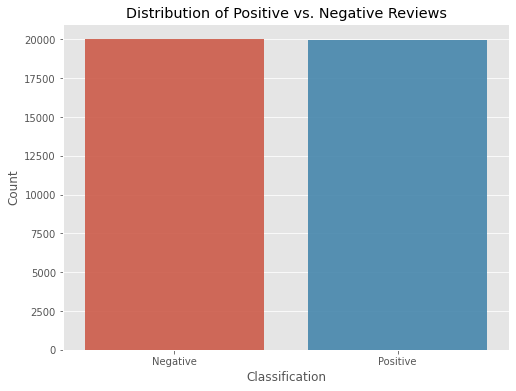

In [23]:
values = df["label"].value_counts().values
plt.figure(figsize=(8, 6))
sns.barplot(x=["Negative", "Positive"], y=values, alpha=0.9)

plt.title("Distribution of Positive vs. Negative Reviews")
plt.ylabel("Count")
plt.xlabel("Classification")

In [24]:
df.groupby("label").count()

,text,length
label,,
0,20019,20019
1,19981,19981


Our distribution is roughly equal, with ~20,000 in each. This makes for great data in terms of analysis, as there isn't any lopsided-ness to it. Next, we can investigate the metrics associated with the length of the text.

In [25]:
df.groupby("label")["length"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,20019.0,1292.536990,942.220087,32.0,705.0,973.0,1571.0,8969.0
1,19981.0,1328.083279,1032.236721,65.0,690.0,972.0,1621.0,13704.0


From here, we can see most reviews are in the range of ~300 to ~2,300 words. However, both have reviews that are far past this. Given this, we can analyze the distribution of length in relation to the classification of the reviews.

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

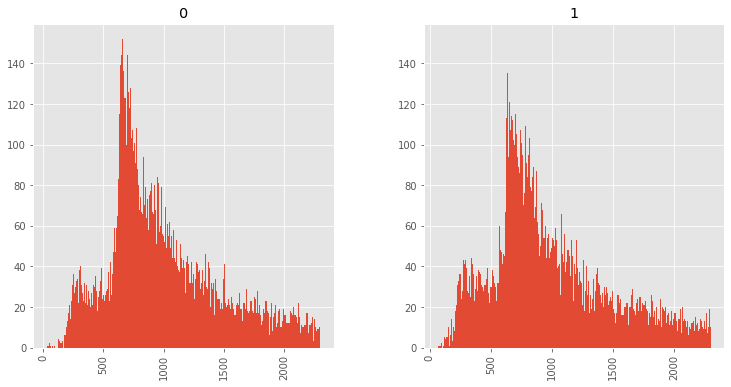

In [36]:
threshold = 2300
df[df["length"] < threshold].hist("length", by="label", bins=500, figsize=(12, 6))

From this, we can see a majority of the reviews, both for positive and negative, lie with in the range 500 to 1250. We can zoom in more, but what I want to see is the correlation between long reviews and their classification.

,text,length
label,,
0,2398,2398
1,2739,2739


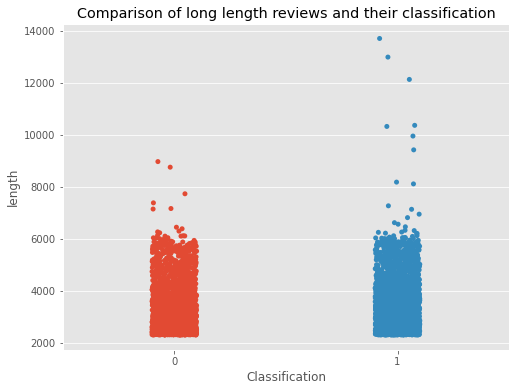

In [50]:
plt.figure(figsize=(8, 6))
sns.stripplot(y="length", x="label", data=df[df["length"] > threshold])
plt.title("Comparison of long length reviews and their classification")
plt.xlabel("Classification")
df[df["length"] > threshold].groupby("label").count()

It appears that, by a small margin, longer reviews are positive. We can analyze the correlation as well.

In [54]:
print(df[df["length"] > threshold].corr())
print()
print(df[df["length"] > threshold].corr("spearman"))

           label    length
label   1.000000  0.044712
length  0.044712  1.000000

           label    length
label   1.000000  0.044789
length  0.044789  1.000000


As I thought, longer length reviews are somewhat positively correlated with Positive Classification (1). 

### Feature Extraction
#### Stemming

The first step in preprocessing this dataframe is stemming the words. This is accomplished through a few different means. the way I chose is to do lemmatization. The main goal of this is to break a word down to its root. This process is vital, as it limits our features by removing plurals and such. 

The lemmatizer I chose comes from [Princeton's WordNet](https://wordnet.princeton.edu/). It does a wonderful job of lemmatizing synonyms as it tries to detect them. 

In [ ]:
lemmatizer = WordNetLemmatizer()